# SPH TESTING

Code based on the tutorials here: 

https://philip-mocz.medium.com/create-your-own-smoothed-particle-hydrodynamics-simulation-with-python-76e1cec505f1

https://github.com/zaman13/Modeling-of-Neutron-Stars/

### Notes: 
- Calculates density from mass times the gradient of the smoothing function.
- Defines 3D Gausssian Smoothing kernel 
- Euler's Method for iterating pressure, density as a function of distance


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py

In [1]:
def W(x,y,z,h):
    """ Defined Gausssian Smoothing kernel (3D).
    (x is a vector/matrix of x positions, y is a vector/matrix of y positions. 
    z is a vector/matrix of z positions, h is smoothing length, w is the evaluated smoothing function.) """
    r = np.sqrt(x**2 + y**2 + z**2) 
    return (1.0 / (h*np.sqrt(np.pi)))**3 * np.exp( -r**2 / h**2) # return w
    
def gradW(x,y,z,h):
    """ Gradient of smoothing kernel. 
    (x is a vector/matrix of x positions, y is a vector/matrix of y positions,  
    z is a vector/matrix of z positions, h is the smoothing length, wx, wy, wz  is the evaluated gradient)"""
    r = np.sqrt(x**2 + y**2 + z**2)  
    n = -2 * np.exp( -r**2 / h**2) / h**5 / (np.pi)**(3/2)
    return n*x, n*y, n*z  # (gradient in the x, y, and z directions)
    
def getPairwiseSeparations(ri, rj):
    """ Just finds Cartesian Pairwise Separations between 2 points. ri is an M x 3 matrix of positions, rj    is an N x 3 matrix of positions dx, dy, dz   are M x N matrices of separations. """
    M = ri.shape[0]
    N = rj.shape[0]
    rix = ri[:,0].reshape((M,1)) # positions ri = (x,y,z)
    riy = ri[:,1].reshape((M,1))
    riz = ri[:,2].reshape((M,1))
    rjx = rj[:,0].reshape((N,1)) # other set of points positions rj = (x,y,z)
    rjy = rj[:,1].reshape((N,1))
    rjz = rj[:,2].reshape((N,1))
    return rix - rjx.T , riy - rjy.T, riz - rjz.T # (dx, dy, dz) # return matrices that store all pairwise particle separations: r_i - r_j

def getDensity(r, pos, m, h, mVals = np.asarray([None]), rVals = np.asarray([None])):
    """ Get Density at sampling loctions from SPH particle distribution. 
    r  is an M x 3 matrix of sampling locations, pos, is an N x 3 matrix of SPH particle positions 
    m  is the particle mass, h is the smoothing length, rho is M x 1 vector of accelerations. """
    M = r.shape[0] # number of points.
    dx, dy, dz = getPairwiseSeparations(r, pos); # 3 N x N Matrices. Returns the pairwise seperations between the desired sampling points (r) and our particle locations. 
###############################################################

    # Calculate density from mass times the gradient of the smoothing function.
    
    if mVals.any() == None: # original simulation case. 
        rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1)) # calculates density from m times the gradient of the smoothing function.
    else:
        rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
        
        mVals = get_mVals_from_points(r, pos, dx,dy,dz, h, mVals,rVals)
        # scale R values to fit the data
        rho = np.sum( mVals * W(dx, dy, dz, h), 1 ).reshape((M,1))  # I'm not sure if mvals locations correspond to the locations where the gradient is being calculated.   
        
###############################################################
    return rho # rho is a M by 1 matrix? good. Each point has a density.

def get_mVals_from_points(r, pos, dx,dy,dz, h, mVals,rVals):
    """ 
    Given r, the radial distance scale (N x 1) and pos, the point coordinates (cartesian)
    dx dy dz is a distance separation between the radial distance scale and the corresponding point (nxn each I think?)
    
    """
    radial_distances = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2) # r = sqrt(x^2 + y^2 + z^2)
    # There should be N radial distances. 
    
    # This is a terrible, rudimentary way of doing this, but for now we're going to use literally the closest point in mvals for m.
    l = []
    
    for idx in range(len(mVals)):
        r = idx/len(mVals)*rVals[-1]
        l.append(r)
    mVals_scaled = []
    
    for i in range(len(radial_distances)): # use literally the closest point in mvals for m.
        x = radial_distances[i]
        difference_array = np.absolute(l-x)
        ix = difference_array.argmin()
        closest_mVal = mVals[ix]
        mVals_scaled.append(closest_mVal)

    return np.asarray(mVals_scaled)
    
def getPressure(rho, k, n, Pvals = np.asarray([None])):
    """ Equation of State. rho- vector of densities, k-equation of state constant, n-polytropic index, P-pressure. """
    if Pvals.any() == None: 
        P = k * rho**(1+1/n) # This quantity is equal to the pressure. (P = k * rho**(1+1/n))
    else:
        P = Pvals # I THINK!!!
    return P 
    
def getAcc(pos, vel, m,h,k,n, lmbda, nu, Mvals = np.asarray([None]), Nvals = np.asarray([None]),Pvals = np.asarray([None])):
    """ Calculate the acceleration on each SPH particle, 'pos' is an N x 3 matrix of positions, 'vel' is an N x 3 matrix of velocities, m is the particle mass, h is the smoothing length, k is equation of state constant, n is polytropic index, lmbda is external force constant, nu is viscosity, a is N x 3 matrix of accelerations """ 
    N = pos.shape[0] # Number of particles
    rho = getDensity( pos, pos, m, h , Mvals, Nvals) # Calculate densities at the position of the particles
    P = getPressure(rho, k, n, Pvals) # Get the pressures
    
    dx, dy, dz = getPairwiseSeparations( pos, pos ) # Get pairwise distances
    dWx, dWy, dWz = gradW( dx, dy, dz, h )# Get pairwise gradients
    
    ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1)) # Add x Pressure contribution to accelerations
    ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1)) # Add y Pressure contribution to accelerations
    az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1)) # Add z Pressure contribution to accelerations

    a = np.hstack((ax,ay,az)) # pack together the acceleration components
    a -= lmbda * pos # Add external potential force
    a -= nu * vel # Add viscosity
    return a

In [2]:
##### Neutron Star Mass (Pressure and Density Iteration) Calculation
hc = 197.327                # Conversion factor in MeV fm (hut * c)
G = hc * 6.67259e-45        # Gravitational constant
Ms = 1.1157467e60
rho_s = 1665.3              # Central density (density at r = 0)
M0 = (4*3.14159265*(G**3)*rho_s)**(-0.5)
R0 = G*M0
mn = 938.926                # Mass of neutron in MeV c^-2

def rho_Zamman(p):
    """ density from pressure NS, source: https://github.com/zaman13/Modeling-of-Neutron-Stars/ """
    n = (p*rho_s/363.44)**(1./2.54)
    return (236. * n**2.54 + n *mn)/rho_s 

def dp_dr_Zamman(r,m,p,flag):
    """ pressure dependence on radius NS, source: https://github.com/zaman13/Modeling-of-Neutron-Stars/ """
    if flag == 0:                              # classical model
        y = -m*rho_Zamman(p)/(r**2 + 1e-20)
    else:                                      # relativistic model
        rh = rho_Zamman(p)                            
        y = -(p+rh)*(p*r**3 + m)/(r**2 - 2*m*r + 1e-20)
    return y


def dm_dr_Zamman(r,m,p):
    """ Mass dependence on radius. """
    return rho_Zamman(p)*r**2

def EulerSolver(r,m,p,h,flag):
    """ Euler Solver which iterates P and mass"""
    y = np.zeros(2)
    y[0] = m + dm_dr_Zamman(r,m,p)*h
    y[1] = p + dp_dr_Zamman(r,m,p,flag)*h
    return y

# Function for determining initial value of n(r=0)
def initial_n(): # I don't know what n is honestly...
    n = 1
    err = 1
    tol = 1e-15
    count = 0
    # Newton-Raphson method
    while err > tol : 
        count += 1
        fn = n*mn + 236*n**(2.54) - rho_s
        dfn = mn + 236*2.54*n**(1.54)
        temp = n - fn/dfn
        err = np.abs(n-temp)
        n = temp
    print("Newton-Raphson Converged after ", count, "iterations")
    return n

def mplot_Zamman(fign,x,y,xl,yl,clr,lbl):
    py.figure(fign)
    py.xlabel(xl)    
    py.ylabel(yl)
    return py.plot(x,y,clr, linewidth =2.0, label = lbl)
 

In [3]:
# Below is for the main N-body simulation.
plotRealTime = False # switch on for plotting as the simulation goes along
    
############# Star Simulation Time Iteration Constants (General)

np.random.seed(42) # set the random number generator seed
N         = 100    # Number of particles
t_0         = 0      # current time of the simulation
tEnd      = 12     # time at which simulation ends
dt        = 0.04   # timestep
# M         = 2      # star mass
#R         = 0.75   # star radius
h         = 0.1    # smoothing length
k         = 0.1    # equation of state constant
n         = 1      # polytropic index
nu        = 1      # damping
Nt = int(np.ceil(tEnd/dt)) # number of timesteps
#M = 0.5 # uncomment for the other cases.


In [4]:
def get_NS_mass_and_plot(label, rho_val, print_details):
    ####################################################################################    
    ############ Calculate the value of NS Mass: Iterate over P, rho #########
            ## source code: https://github.com/zaman13/Modeling-of-Neutron-Stars/
            ## Using Plank system units (hcut = c = 1).  Ref.: http://newfi.narod.ru/Newfi/Constants.htm

    lbl = "\n------- For " + label + " -----\n"
    print(lbl)
    py.figure(1)
    py.clf
    py.figure(2)
    py.clf

    #### PREESURE AND DENSITY ITERATION OVER SPACE
    r1 = np.linspace(0,15,N) # why 15? Oh. 15 blocks where the density will be evaluated inside the star??
    r = r1
    h = r[1]-r[0] # we have re-defined the smoothing length here. Not sure if this will cause problems...
    m = np.zeros(N) # each data point has a mass. They are all 0 at the moment.
    p = np.zeros(N) # each data point has a pressure. They are all 0 at the moment.
    rh = np.zeros(N)
    ni = initial_n()

        # Initial values
    r1[0] = 0
    m[0] = 0 # 
    p[0] = 363.44 * (ni**2.54)/rho_val
    rh[0] = 1
    mf = 0
    rf = 0



    print("Initial number density, ni = ", ni)
    print("Initial Pressure, P[0] = ", p[0])
    print("Simulation range, R = 0 to ", r[-1]*R0*1e-18, "km") 
    tol = 9e-5

    # Only classical model is used here
    for k in range(0,2):
        flag = 0
        for i in range(0,N-1):
            [m[i+1], p[i+1]] = EulerSolver(r[i],m[i],p[i],h,0) # Euler's Method
            rh[i+1] = rho_Zamman(r[i])
            if p[i+1] < tol:
                rf = r[i]
                mf = m[i]
                break

        if i == N-2:
            print("Program didn't converge to P = 0, extend the maximum value of r")
        else:
            print("P <", tol, "found after", i, "runs")

        m = m[0:i+2] # Update the mass of each point
        p = p[0:i+2] # Update the pressure of each point
        rh = rh[0:i+2]
        r = r[0:i+2]
        lbl = label + " Euler's Method with h = " + str(h)
        if label == "NS1":
            clr = "red"
        else:
            clr = "blue"

        print("==============================================")
        print("Initial density, rho_val = ", rho_val, "MeV/fm3")
        print("Total mass = ", mf*M0/Ms, "times Solar mass")
        print("Radius of the Neutron star = ", rf*R0*1e-18, "km")

        # PLOT
        mplot_Zamman(1,r*R0*1e-18,p*rho_val,'Distance, $r$ (km)',r'Pressure, $P$ $(MeVfm^{-3})$',clr,lbl) # Plot r and p
        mplot_Zamman(2,r*R0*1e-18,m*M0/Ms,'Distance, $r$ (km)',r'Mass, $M/M_{sun}$',clr,lbl) # Plot m and p

        # Extracted the values from the plots.
        Rvals = r #*R0*1e-18 # r is N x 1 matrix of points.
        Mvals = m # *M0/Ms # M is N x 1 matrix of points.
        Pvals = p # *rho_val # P is N x 1 matrix of points.


    # Figure Specifics (Plot)
    py.figure(1)
    q = py.legend(loc = 0)
    q.draw_frame(False)
    py.figure(2)
    q=py.legend(loc = 0)
    q.draw_frame(False)

    if print_details:
        print("")
        print("=================================================")
        print("The constants R0 is = ", R0*1e-18, "km (10 km unit is confusing, so it is avoided)")
        print("The constants M0 is = ", M0/Ms, "times Solar mass")
        
    return Rvals, Mvals, Pvals

In [37]:
def make_star(label, rho_val, M, R, Mvals, Rvals, Pvals):
    ####################################################################################
    ############# Star Simulation Time Iteration : Generate Initial Conditions###########################################################################################

    lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  #is external force constant, ~ 2.01

    ########*########*
    # m     = M/N                    # single particle mass, previously just a number.
    m  = M/N # Mvals # now m is a N x 1 vector (containing the mass of each point??? )
    ########*########*

    t = t_0
    pos = np.random.randn(N,3)   # randomly select positions and velocities from initialized seed
    vel = np.zeros(pos.shape)    # randomly select positions and velocities 
    # positions and velocities are N x 3 matrices

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu ) # calculate initial gravitational accelerations
    # acc is also an N x 3 matrix (so new we have pos, vel, acc for x,y,z.)

    ##### THIS BLOCK IS FOR STAR PLOT
    fig = plt.figure(figsize=(4,5), dpi=80) 
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:2,0])
    ax2 = plt.subplot(grid[2,0])
    
    rr = np.zeros((100,3))
    rlin = np.linspace(0,1,100)
    rr[:,0] =rlin
    rho_analytic = lmbda/(4*k) * (R**2 - rlin**2) 
    
        ##### END OF PLOT BLOCK

    #################################################################################
    #################################################################################
        #################################################################################

    for i in range(Nt): # Star Simulation Time Interation Main Loop
        vel += acc * dt/2 # (1/2) kick # adds acceleration
        pos += vel * dt # particle motion
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu, Mvals, Rvals) # get new Nx3 matrix of accelerations based on new pos,v
        vel += acc * dt/2 # (1/2) kick # not sure why we add accelleration again.
        t += dt # update time
        rho = getDensity(pos, pos, m, h) # get updated density for each point based on m, h. 

        #################################################################################
    #################################################################################
    #################################################################################

        plotRealTime = False
        if plotRealTime or (i == Nt-1):
            plt.sca(ax1)
            plt.cla()
            cval = np.minimum((rho-3)/3,1).flatten()
            plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
            ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1,0,1])
            ax1.set_yticks([-1,0,1])
            ax1.set_facecolor('black')
            ax1.set_facecolor((.1,.1,.1))
            plt.title(label)

            plt.sca(ax2)
            plt.cla()
            ax2.set(xlim=(0, 1), ylim=(0, 3))
            ax2.set_aspect(0.1)
            plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
            rho_radial = getDensity( rr, pos, m, h )
            plt.plot(rlin, rho_radial, color='blue')
            plt.xlabel('Radius')
            plt.ylabel('Density')
            lbl = label + '_simple_neutron_sph.png'
            plt.savefig(lbl,dpi=240)
            plt.pause(0.001)

    plt.show()
    
    return True

In [6]:
## Second star
rho_s_2 = 1000

M_1_val = 1
M_2_val = 0.5
R_1_val = 0.7
R_2_val = 0.75


------- For NS1 -----

Newton-Raphson Converged after  5 iterations
Initial number density, ni =  1.2918969375342138
Initial Pressure, P[0] =  0.4182722266764404
Simulation range, R = 0 to  90.36486611870906 km
P < 9e-05 found after 17 runs
Initial density, rho_val =  1665.3 MeV/fm3
Total mass =  10.956908354777141 times Solar mass
Radius of the Neutron star =  15.517199232505595 km
P < 9e-05 found after 17 runs
Initial density, rho_val =  1665.3 MeV/fm3
Total mass =  10.956908354777141 times Solar mass
Radius of the Neutron star =  15.517199232505595 km

------- For NS2 -----

Newton-Raphson Converged after  5 iterations
Initial number density, ni =  1.2918969375342138
Initial Pressure, P[0] =  0.6965487390842762
Simulation range, R = 0 to  90.36486611870906 km
P < 9e-05 found after 17 runs
Initial density, rho_val =  1000 MeV/fm3
Total mass =  13.714727335942142 times Solar mass
Radius of the Neutron star =  15.517199232505595 km
P < 9e-05 found after 17 runs
Initial density, rho_va

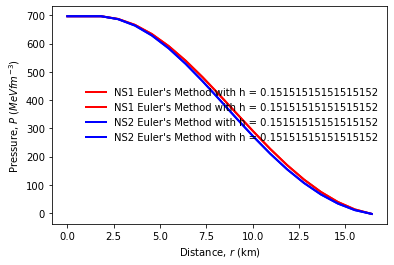

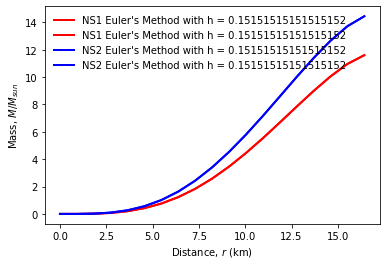

In [7]:
print_det = False
label1 = "NS1"
label2 = "NS2"
M1_val, R1_val, P1_val = get_NS_mass_and_plot(label1, rho_s, print_det)
M2_val, R2_val, P2_val = get_NS_mass_and_plot(label2, rho_s_2, print_det)

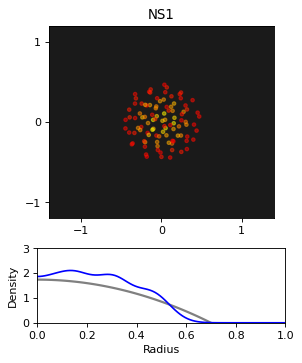

True

In [38]:
make_star(label1, rho_s, M_1_val, R_1_val, M1_val, R1_val, P1_val)

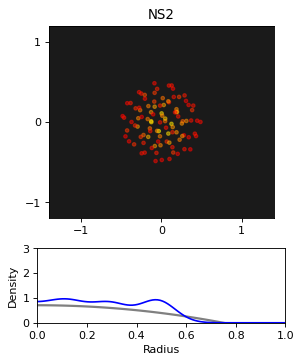

True

In [39]:
make_star(label2, rho_s_2, M_2_val, R_2_val, M2_val, R2_val, P2_val)